In [445]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import copy
import itertools as it
import json
import os
import sys
import time

import cv2
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import networkx as nx
import numpy as np
import torch
import vizdoom as vzd

from rlpyt.envs.vizdoom.vizdoom_env import VizDoomEnv
import rlpyt.models.resnet as resnet
from rlpyt.models.dqn.dsr.dsr_model import DsrModel
from rlpyt.models.dqn.dsr.tcf_model import FixedVizDoomModel

vzd_dir = 'vizdoom_data'
import keras
import tensorflow as tf

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

from itertools import tee, islice
def nwise(iterable, n=2):                                                      
    iters = tee(iterable, n)                                                     
    for i, it in enumerate(iters):                                               
        next(islice(it, i, i), None)                                               
    return zip(*iters)

np.random.seed(333)
device = torch.device('cuda', index=0)

In [99]:
with open('../experiments/configs/small-eval-settings.json') as f:
    small_goals = json.load(f)

In [100]:
with open('../experiments/configs/memory-small-full.json') as f:
    small_config = json.load(f)
small_config['env']['config'] = '../' + small_config['env']['config']

In [101]:
with open('../experiments/configs/memory-train-full.json') as f:
    train_config = json.load(f)
train_config['env']['config'] = '../' + train_config['env']['config']

In [102]:
small_env = VizDoomEnv(**small_config['env'])
train_env = VizDoomEnv(**train_config['env'])

In [103]:
levels = ['easy', 'medium', 'hard', 'hardest']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

In [104]:
def plot_topdown(env, fig):
    env.reset()
    state = env.state

    for s in state.sectors:
        # Plot sector on map
        for l in s.lines:
            if l.is_blocking:
                fig.plot([l.x1, l.x2], [l.y1, l.y2], color='black', linewidth=2)

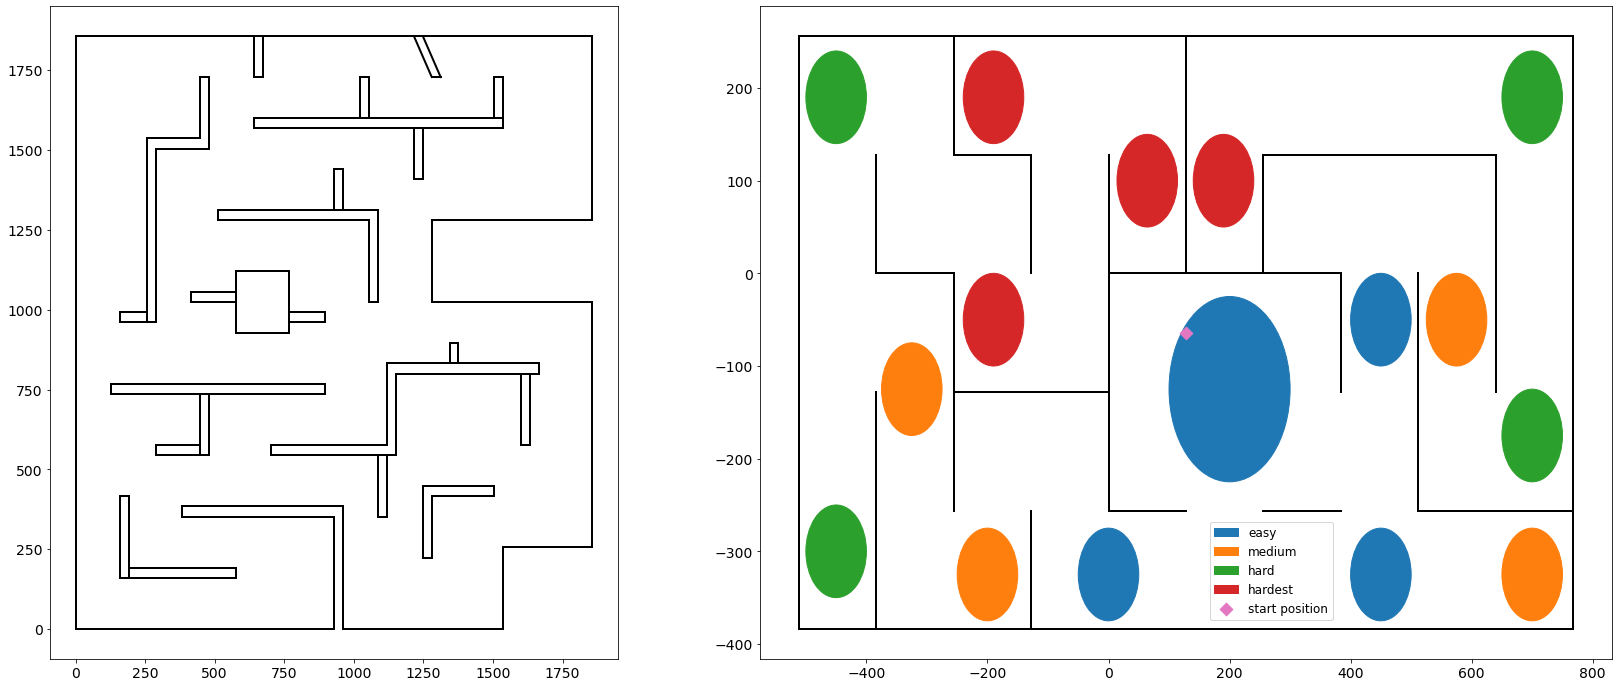

In [147]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(28, 12), gridspec_kw={'width_ratios': [1, 1.5]})
ax1.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)

plot_topdown(train_env, ax1)
plot_topdown(small_env, ax2)
circles = []
for level, color in zip(levels, colors):
    goal_areas = small_goals[level]
    for goal_area in goal_areas:
        x, y, r = goal_area
        circle = plt.Circle((x, y), r, color=color, label=level, zorder=-1)
        ax2.add_artist(circle)
    circles.append(circle)
agent = ax2.scatter(*small_config['env']['start_position'][:2], s=81, color='tab:pink', marker='D', label='start position', zorder=1)
ax2.legend(handles=[*circles, agent], loc='lower center', bbox_to_anchor=(0.60, 0.05), fontsize=12)
plt.savefig('images/mazes.png', bbox_inches='tight')

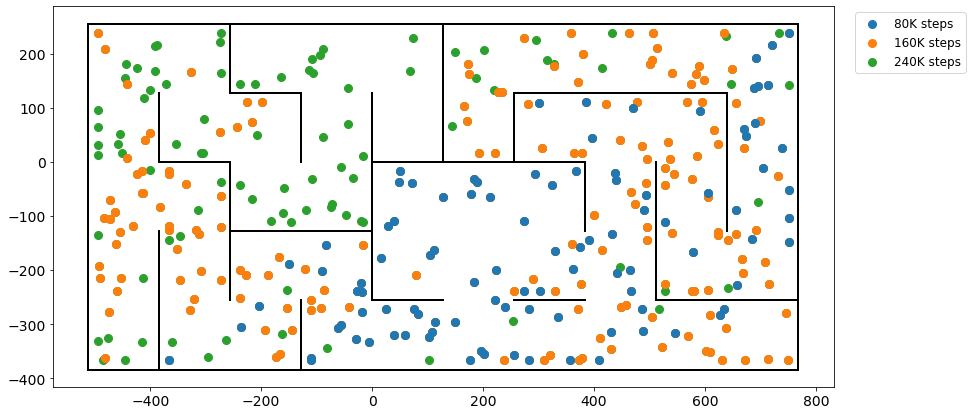

In [547]:
plt.figure(figsize=(14, 7))

landmarks = np.load('../data/local/20200925/vizdoom/run_6/landmarks_itr_9999.npz')
positions = landmarks['positions']
plot_topdown(small_env, plt)
plt.scatter(positions[:, 0], positions[:, 1], label='80K steps', s=64, zorder=3)

landmarks = np.load('../data/local/20200925/vizdoom/run_6/landmarks_itr_19999.npz')
positions = landmarks['positions']
plt.scatter(positions[:, 0], positions[:, 1], label='160K steps', s=64, zorder=2)

landmarks = np.load('../data/local/20200925/vizdoom/run_6/landmarks_itr_29999.npz')
positions = landmarks['positions']
plt.scatter(positions[:, 0], positions[:, 1], label='240K steps', s=64, zorder=1)

plt.tick_params(labelsize=14)
plt.legend(fontsize=12, bbox_to_anchor=(1.02, 1))
plt.savefig('images/landmark_expansion.png', bbox_inches='tight')

In [172]:
with open('../experiments/configs/2589-small-fixed-start-goal-pairs.json') as f:
    small_goal_pairs = json.load(f)

In [198]:
small_config['agent']['feature_model_kwargs']['fixed_weights_path'] = '../' + \
    small_config['agent']['feature_model_kwargs']['fixed_weights_path'] 

In [449]:
feature_model = FixedVizDoomModel(**small_config['agent']['feature_model_kwargs'])
feature_model.to(device)

FixedVizDoomModel(
  (encoder): Linear(in_features=1, out_features=1, bias=True)
)

In [548]:
weights = torch.load('../data/local/20200922/vizdoom/run_0/itr_249999.pkl', map_location=device)
landmarks = np.load('../data/local/20200922/vizdoom/run_0/landmarks_itr_249999.npz')

In [549]:
dsr_model = DsrModel(train_env.observation_space.shape,
                     train_env.action_space.n, **train_config['agent']['model_kwargs']).to(device)

In [550]:
dsr_model.load_state_dict(weights['agent_state_dict']['model'])
dsr_model.eval()
dsr_model.to(device)

DsrModel(
  (dsr): MlpModel(
    (model): Sequential(
      (0): Linear(in_features=2048, out_features=2048, bias=True)
      (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=2048, out_features=1024, bias=True)
      (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=1024, out_features=14336, bias=True)
    )
  )
  (q_estimate): Linear(in_features=2048, out_features=1, bias=True)
)

In [551]:
def get_s_features(state, norm=True, numpy=True):
    features = feature_model(torch.Tensor(state).unsqueeze(0).to(device))
    s_features = dsr_model(features, mode='dsr')
    if norm:
        s_features = torch.mean(s_features, dim=1)
        s_features = s_features / torch.norm(s_features, p=2, dim=1, keepdim=True)
    if numpy:
        s_features = s_features.detach().cpu().numpy().squeeze()
    return s_features

In [552]:
positions = landmarks['positions']
N = len(positions)

dsr = landmarks['dsr']
norm_dsr = dsr / np.linalg.norm(dsr, ord=2, axis=1, keepdims=True)
dsr_sim = np.matmul(norm_dsr, norm_dsr.T)
dsr_sim[np.eye(N, dtype=bool)] = -1
features = landmarks['features']
norm_features = features / np.linalg.norm(features, ord=2, axis=1, keepdims=True)
feature_sim = np.matmul(norm_features, norm_features.T)

edge_random_steps = landmarks['edge_random_steps']
edge_random_transitions = landmarks['edge_random_transitions']
edge_subgoal_steps = landmarks['edge_subgoal_steps']
edge_subgoal_failures = landmarks['edge_subgoal_failures']
edge_subgoal_transitions = landmarks['edge_subgoal_transitions']

random_steps = edge_random_steps + np.tril(edge_random_steps, -1).T
random_transitions = edge_random_transitions + np.tril(edge_random_transitions, -1).T

subgoal_steps = edge_subgoal_steps + np.tril(edge_subgoal_steps, -1).T
subgoal_failures = edge_subgoal_failures + np.tril(edge_subgoal_failures, -1).T
subgoal_transitions = edge_subgoal_transitions + np.tril(edge_subgoal_transitions, -1).T

average_random_steps = random_steps / np.clip(random_transitions, 1, None)
average_subgoal_steps = subgoal_steps / np.clip(subgoal_transitions, 1, None)

transitions = random_transitions + subgoal_transitions

In [554]:
print('Number of landmarks:', N)
print('Number of non-zero random transitions:', np.argwhere(random_transitions > 0).shape[0])
percentile = 50
threshold = np.percentile(random_transitions[random_transitions > 0], percentile)
print('{} percentile of random transitions:'.format(percentile), 
      threshold)

temporally_nearby_threshold = max(N // 10, 10)
temporally_nearby_landmarks = np.tril(np.triu(np.ones((N), dtype=bool), 1), temporally_nearby_threshold)

subgoal_edges = np.argwhere(subgoal_transitions > 0)
print('Number of subgoal edges:', subgoal_edges.shape[0])
failure_edges = np.argwhere(subgoal_failures > 0)
print('Number of failure edges:', failure_edges.shape[0])

true_edges = random_transitions >= threshold
# true_edges = temporally_nearby_landmarks & true_edges

k = 5
nearest_neighbors = np.argpartition(true_edges * random_transitions, -k)[:, -k:]
k_filter = np.zeros((N, N), dtype=bool)
idx = np.vstack([np.arange(N)] * k).T
k_filter[idx, nearest_neighbors] = True
true_edges = k_filter & true_edges

# true_edges = (subgoal_failures <= 1) & true_edges

edge_weights = true_edges * (np.exp(-1 * random_transitions))
edge_weights[(edge_weights > 0) & (subgoal_failures > 1)] = \
    edge_weights[(edge_weights > 0) & (subgoal_failures >1)] + 5000

edges = np.argwhere(edge_weights > 0)
print('Number of edges:', edges.shape[0])

Number of landmarks: 2433
Number of non-zero random transitions: 41219
50 percentile of random transitions: 1.0
Number of subgoal edges: 8456
Number of failure edges: 2552
Number of edges: 10121


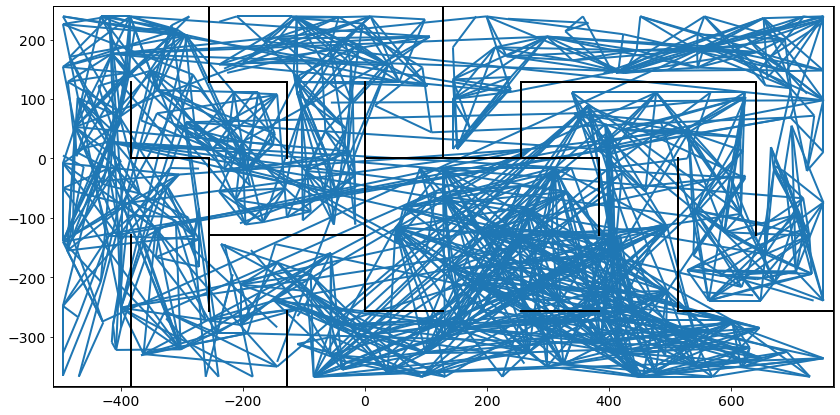

In [542]:
starts = positions[edges[:, 0], :2]
ends = positions[edges[:, 1], :2]
lc = mc.LineCollection(list(zip(starts, ends)),
                       linewidths=2)
fig, ax = plt.subplots(figsize=(14, 7))
plt.tick_params(labelsize=14)
ax.set_xlim(small_env.min_x, small_env.max_x)
ax.set_ylim(small_env.min_y, small_env.max_y)
plot_topdown(small_env, ax)
ax.add_collection(lc)
plt.savefig('images/edges-failures-temporal-landmarks.png')

In [ ]:
with open('../experiments/configs/9794-train-start-goal-pairs.json') as f:
    train_goal_pairs = json.load(f)

In [521]:
goal_idx = 0
start_pos, goal_pos = small_goal_pairs['hard'][goal_idx]
start_state, start_pos = small_env.get_obs_at(start_pos, idx=3)
goal_state, goal_pos = small_env.get_obs_at(goal_pos, idx=-1)
start_sf = get_s_features(start_state)
goal_sf = get_s_features(goal_state)

start_sim = np.matmul(norm_dsr, start_sf).max()
start_landmark = np.matmul(norm_dsr, start_sf).argmax()

goal_sim = np.matmul(norm_dsr, goal_sf.T).max()
goal_landmark = np.matmul(norm_dsr, goal_sf.T).argmax()

print('SF start:', start_landmark)
print('SF goal:', goal_landmark)

SF start: 38
SF goal: 231


In [522]:
graph = nx.from_numpy_array(edge_weights)
has_path = nx.has_path(graph, start_landmark, goal_landmark)
if has_path:
    path = nx.shortest_path(graph, start_landmark, goal_landmark, weight='weight')
    print('Found path:', path)
else:
    print('No path from {} to {}'.format(start_landmark, goal_landmark))

Found path: [38, 1, 0, 25, 7, 11, 24, 28, 30, 31, 53, 39, 86, 132, 135, 138, 141, 147, 174, 171, 182, 225, 231]


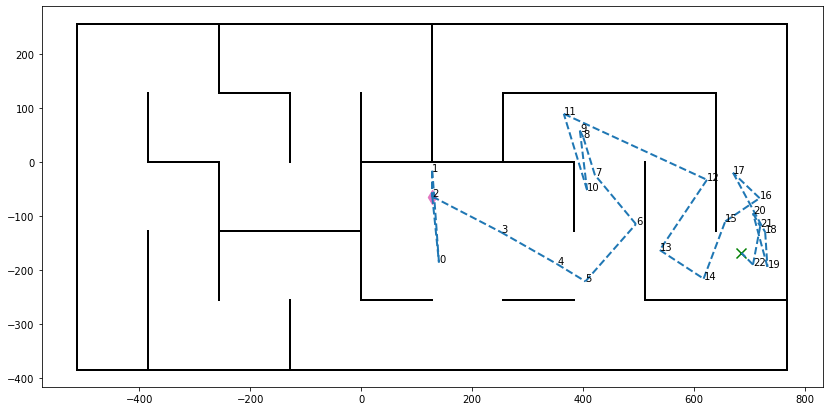

In [524]:
plt.figure(figsize=(14, 7))
plot_topdown(small_env, plt)
for i, landmark in enumerate(path):
     plt.text(*positions[landmark, :2], str(i))

lines = []
full_path = [start_pos[:2], *positions[path, :2], goal_pos[:2]]
full_path = list(map(tuple, full_path))
lines = list(zip(full_path, full_path[1:]))

# lc = mc.LineCollection([*lines[:30], *lines[31:]], linewidths=2, linestyle='--', label='Landmark Path')
# plt.gcf().gca().add_collection(lc)
# lc = mc.LineCollection(lines[30:31], linewidths=2, linestyle=':', color='red', label='Bad Edge')
# plt.gcf().gca().add_collection(lc)

lc = mc.LineCollection(lines, linewidths=2, linestyle='--', label='Landmark Path')
plt.gcf().gca().add_collection(lc)

plt.scatter(*start_pos[:2], marker='d', s=100, color='tab:pink', label='Start')
plt.scatter(*goal_pos[:2], marker='x', s=100, color='green', label='Goal')
# plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1))
plt.savefig('images/random-good-path.png', bbox_inches='tight')

In [ ]:
with open('../experiments/configs/22')